# Section2 Project / 911상황실 신고 데이터

참조:
https://www.kaggle.com/datasets/aayushmishra1512/911calls-historic-data?select=911.csv

**특성 정보**

lat 위도

lng 경도

desc 호출장소에대한 설명

zip 우편번호

title 신고내용

timeStamp 신고시간

twp 신고장소

addr 주소

e 참석여부

EMS CALLS Y=1, N=0


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -U category_encoders
!pip install -U pandas-profiling==3.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 80 kB 743 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 261 kB 654 kB/s 
     |████████████████████████████████| 102 kB 5.2 MB/s 
     |████████████████████████████████| 596 kB 8.9 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
     |████████████████████████████████| 3.1 MB 30.3 MB/s 
     |████████████████████████████████| 690 kB 45.3 MB/s 
     |████████████████████████████████| 11.1 MB 40.3 MB/s 
     |████████████████████████████████| 303 kB 67.3 MB/s 
     |████████████████████████████████| 812 kB 42.2 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27098 sha256=5f22becd2c6bea77ecbe09f6629f83d6057868bf43ba76f4447cb740c0f50d04
  Stored in direc

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

%matplotlib inline

df=pd.read_csv('/content/drive/MyDrive/ai13/911.csv')

df.head()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


lat        lng                                               desc  \
0  40.297876 -75.581294  REINDEER CT & DEAD END;  NEW HANOVER; Station ...   
1  40.258061 -75.264680  BRIAR PATH & WHITEMARSH LN;  HATFIELD TOWNSHIP...   
2  40.121182 -75.351975  HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...   
3  40.116153 -75.343513  AIRY ST & SWEDE ST;  NORRISTOWN; Station 308A;...   
4  40.251492 -75.603350  CHERRYWOOD CT & DEAD END;  LOWER POTTSGROVE; S...   

       zip                    title            timeStamp                twp  \
0  19525.0   EMS: BACK PAINS/INJURY  2015-12-10 17:40:00        NEW HANOVER   
1  19446.0  EMS: DIABETIC EMERGENCY  2015-12-10 17:40:00  HATFIELD TOWNSHIP   
2  19401.0      Fire: GAS-ODOR/LEAK  2015-12-10 17:40:00         NORRISTOWN   
3  19401.0   EMS: CARDIAC EMERGENCY  2015-12-10 17:40:01         NORRISTOWN   
4      NaN           EMS: DIZZINESS  2015-12-10 17:40:01   LOWER POTTSGROVE   

                         addr  e  
0      REINDEER CT & DEAD END  1  
1  BRIAR PATH & WHITEMARSH LN  1  
2                    HAWS AVE  1  
3          AIRY ST & SWEDE ST  1  
4    CHERRYWOOD CT & DEAD END  1

#1. 데이터셋 선정 911 상황실 신고 정보
***
- 데이터 선정 이유 및 문제 정의 , EMS(응급상황) 신고 예측하기
- 분류 /  접근 ,  EMS(응급),Fire(화재),(Traffic)교통
- 해결하고자 하는 문제 정의에 적절한 타겟 설정
- 타겟을 잘 설명할 수 있는 특성에 대한 가설 설정- 911상황실에 걸려 올 전화가 응급신고일 경우를 예측하기
***


In [4]:
df['title'].value_counts() # 데이터셋에 타겟이 주어져있지 않기 때문에, 타겟을 만들어 줄 특성을 살펴본다.

Traffic: VEHICLE ACCIDENT -        23066
Traffic: DISABLED VEHICLE -         7702
Fire: FIRE ALARM                    5496
EMS: RESPIRATORY EMERGENCY          5112
EMS: CARDIAC EMERGENCY              5012
                                   ...  
EMS: DISABLED VEHICLE                  1
Fire: UNKNOWN MEDICAL EMERGENCY        1
Fire: DIABETIC EMERGENCY               1
EMS: BOMB DEVICE FOUND                 1
Fire: SYNCOPAL EPISODE                 1
Name: title, Length: 110, dtype: int64

#2. 데이터 전처리 eda 시각화
***
- 데이터셋을 모델링에 적합하게 전처리,
- 피쳐와 타겟간의 상관관계에 대한 EDA, 시각화 (.corr)
- 데이터타입 변경 (astype())
- 결측치 처리 (isnull())
- 이상치 처리 (관련검색 해보기)
- 가설에 대한 시각화 결과
- 데이터누수 확인 - 특성공학진행(타겟값으로 사용할 특성 생성- traff)
***

In [5]:
# EMS yes= 1, no= 0
def makeTarget(x) :
  if x.startswith('Fire') | x.startswith('Traffic'): # 응급신고일 경우 1, 화재,교통신고일 경우 0이라고 하는 타겟특성을 만들었다.
    return 0
  if x.startswith('EMS'):
    return 1

df["EMS"] = df['title'].apply(makeTarget) # 기존 신고 종류에는 3가지가 있었다. traffic,ems,fire

In [6]:
#결측치처리

df.fillna(0,inplace=True)

In [7]:
#결측치확인
df.isnull().sum()

lat          0
lng          0
desc         0
zip          0
title        0
timeStamp    0
twp          0
addr         0
e            0
EMS          0
dtype: int64

In [8]:
# 'lat','lng','e','timeStamp','title','desc' = drop columns (위도, 경도, 참석여부, 호출장소에대한 설명, 신고시간 삭제)
df.drop(columns=['lat','lng','e','timeStamp','title','desc'],inplace=True) #타겟특성을 만들때 기본이 된 title 특성과, 그 외 불필요한 특성을 드롭했다.

In [9]:
df.head(20) #처리 후 데이터셋.

zip                twp                                      addr  EMS
0   19525.0        NEW HANOVER                    REINDEER CT & DEAD END    1
1   19446.0  HATFIELD TOWNSHIP                BRIAR PATH & WHITEMARSH LN    1
2   19401.0         NORRISTOWN                                  HAWS AVE    0
3   19401.0         NORRISTOWN                        AIRY ST & SWEDE ST    1
4       0.0   LOWER POTTSGROVE                  CHERRYWOOD CT & DEAD END    1
5   19446.0           LANSDALE                     CANNON AVE & W 9TH ST    1
6   19044.0            HORSHAM                  LAUREL AVE & OAKDALE AVE    1
7   19426.0           SKIPPACK              COLLEGEVILLE RD & LYWISKI RD    1
8   19438.0      LOWER SALFORD             MAIN ST & OLD SUMNEYTOWN PIKE    1
9   19462.0           PLYMOUTH  BLUEROUTE  & RAMP I476 NB TO CHEMICAL RD    0
10      0.0         MONTGOMERY                     RT202 PKWY & KNAPP RD    0
11  19428.0           PLYMOUTH                     BROOK RD & COLWELL LN    0
12  19040.0     UPPER MORELAND             BYBERRY AVE & S WARMINSTER RD    0
13  19027.0         CHELTENHAM                   OLD YORK RD & VALLEY RD    0
14      0.0       UPPER MERION     SCHUYLKILL EXPY & CROTON RD UNDERPASS    0
15  18936.0         MONTGOMERY                   STUMP RD & WITCHWOOD DR    0
16  19446.0           LANSDALE               SUSQUEHANNA AVE & W MAIN ST    1
17  19525.0        NEW HANOVER                   CHARLOTTE ST & MILES RD    1
18  19401.0         NORRISTOWN                         PENN ST & ARCH ST    1
19  18974.0            HORSHAM                COUNTY LINE RD & WILLOW DR    0

#3. 모델링 및 모델 해석
***
- 분류, 회귀 모델에 맞는 모델링 학습과 성능확인
- 기준모델 설정
- 적절한평가지표 사용하고 모델성능 설명
- 교차나 홀드아웃기법을 이용해서 학습과 일반화 성능을 구분
- 순열중요도,pdp,shap을 활용하여 최종모델을 설명
***

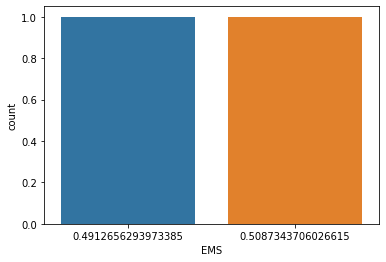

In [10]:
target_bar=df['EMS'].value_counts(normalize=True) #타겟의 기준모델을 확인하기 위해 최빈값을 시각화했다.
sns.countplot(x=target_bar);

In [11]:
df['EMS'].value_counts(normalize=True) # 0.50..


0    0.508734
1    0.491266
Name: EMS, dtype: float64

In [12]:
# 데이터셋을 훈련, 검증, 테스트셋으로 구분하였다.

features = df.drop(['EMS'], axis = 1)    ##target-feature 분리
target = df['EMS']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, train_size=0.8, random_state=2) #  train/test = 80/20, random_state=2
print("테스트셋",X_test.shape)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, train_size = 0.8, random_state = 2) 
print("훈련셋",X_train.shape)
print("검증셋",X_val.shape)

테스트셋 (19899, 3)
훈련셋 (63674, 3)
검증셋 (15919, 3)


In [13]:
#파이프를 만들어주고 addr 컬럼이 카디널리티가 높기 때문에 원 핫 인코딩은 사용하지 않고 Ordinal 인코딩을 사용했다.
pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    XGBClassifier(n_estimators=200
                  , random_state=42
                  , n_jobs=-1
                  , max_depth=30 # 카디널리티가 높은 특성(addr)이 있기 때문에 maxdepth를 늘려보았다.
                  , learning_rate=0.2
                 )
)

pipe.fit(X_train, y_train);

y_pred1 = pipe.predict(X_train)
print('훈련셋 정확도: ', accuracy_score(y_train, y_pred1))
y_pred2 = pipe.predict(X_val)
print('검증셋 정확도: ', accuracy_score(y_val, y_pred2))
y_pred3 = pipe.predict(X_test)
print('테스트셋 정확도: ', accuracy_score(y_test, y_pred3))
print(classification_report(y_pred3, y_test))

훈련셋 정확도:  0.8402644721550397
검증셋 정확도:  0.7205854639110497
테스트셋 정확도:  0.7274737423991156
              precision    recall  f1-score   support

           0       0.78      0.71      0.75     11137
           1       0.67      0.75      0.71      8762

    accuracy                           0.73     19899
   macro avg       0.73      0.73      0.73     19899
weighted avg       0.73      0.73      0.73     19899



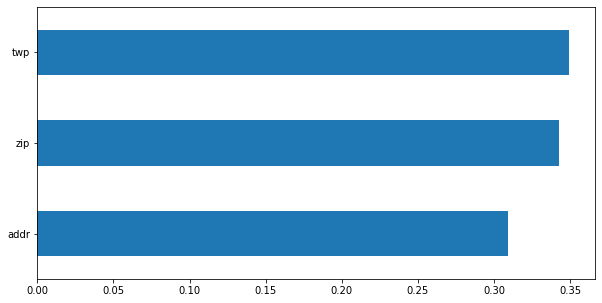

In [14]:
# 특성중요도 (feature importance)
# 어떤 특성들이 모델의 성능에 중요하다, 많이 쓰인다는 정보. 특성의 값에 따라서 타겟값이 증가/감소하느냐와 같은 어떻게 영향을 미치는지에 대한 정보를 알 수 없다.
model_dt = pipe.named_steps['xgbclassifier'] 

importances = pd.Series(model_dt.feature_importances_, df.columns[:-1].tolist())
plt.figure(figsize=(10,5))
importances.sort_values().plot.barh();

In [15]:
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 646 kB/s 
     |████████████████████████████████| 133 kB 6.2 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=d4e07a262d156f87899e78751d47b8260c090f3194062b38802af74ffd18c893
  Stored in directory: /root/.cache/pip/wheels/cc/3c/96/3ead31a8e6c20fc0f1a707fde2e05d49a80b1b4b30096573be
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is

In [16]:
encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train) # 학습데이터
X_val_encoded = encoder.transform(X_val) # 검증데이터

model = XGBClassifier(
    n_estimators=1000,  # early stopping 에 따라 조절된다.
    max_depth=30,        
    learning_rate=0.2,
    n_jobs=-1
)

eval_set = [(X_train_encoded, y_train), 
            (X_val_encoded, y_val)]

model.fit(X_train_encoded, y_train, 
          eval_set=eval_set,
          eval_metric='error', # #(wrong cases)/#(all cases)
          early_stopping_rounds=100
         ) # 100 rounds 동안 스코어의 개선이 없으면 멈춤

[0]	validation_0-error:0.209662	validation_1-error:0.292795
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.201417	validation_1-error:0.292104
[2]	validation_0-error:0.199956	validation_1-error:0.291413
[3]	validation_0-error:0.198291	validation_1-error:0.291727
[4]	validation_0-error:0.195433	validation_1-error:0.291162
[5]	validation_0-error:0.193266	validation_1-error:0.290219
[6]	validation_0-error:0.190706	validation_1-error:0.288398
[7]	validation_0-error:0.18901	validation_1-error:0.289214
[8]	validation_0-error:0.187345	validation_1-error:0.287581
[9]	validation_0-error:0.1859	validation_1-error:0.286701
[10]	validation_0-error:0.184125	validation_1-error:0.286325
[11]	validation_0-error:0.183403	validation_1-error:0.286136
[12]	validation_0-error:0.182225	validation_1-error:0.285822
[13]	validation_0-error:0.181016	validation_1-error:0.2860

XGBClassifier(learning_rate=0.2, max_depth=30, n_estimators=1000, n_jobs=-1)

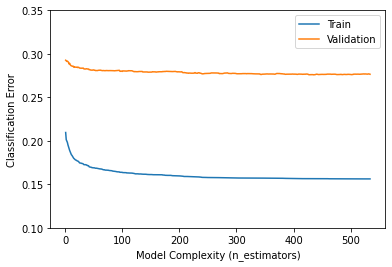

In [17]:
results = model.evals_result()
train_error = results['validation_0']['error']
val_error = results['validation_1']['error']

epoch = range(1, len(train_error)+1)
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.ylabel('Classification Error')
plt.xlabel('Model Complexity (n_estimators)')
plt.ylim((0.1, 0.35)) # Zoom in
plt.legend();

In [18]:
print('검증 정확도', model.score(X_val_encoded, y_val))

print(classification_report(y_val, model.predict(X_val_encoded)))

검증 정확도 0.7239776367862303
              precision    recall  f1-score   support

           0       0.71      0.78      0.74      8057
           1       0.75      0.67      0.71      7862

    accuracy                           0.72     15919
   macro avg       0.73      0.72      0.72     15919
weighted avg       0.73      0.72      0.72     15919



In [19]:
!pip install shap
!pip install -U pdpbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 564 kB 643 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 34.0 MB 2.0 MB/s 
     |████████████████████████████████| 13.1 MB 35.2 MB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.1-py3-none-any.whl size=35758224 sha256=69e0e9df42627c05cf416d7391b6ce99b43cdf2bd22b21b78b8328407ae0db7b
  Stored in directory: /root/.cache/pip/wheels/f4/d0/1a/b80035625c53131f52906a6fc4dd690d8efd2bf8af6a4015eb
Successfully built pdpbox
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.

In [20]:
# 클래스의 비율
y_train.value_counts(normalize=True)

# EMS 0.49 ,NOT 0.50

0    0.508528
1    0.491472
Name: EMS, dtype: float64

In [21]:
ratio =  0.49/ 0.50
ratio

0.98

In [22]:

processor = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]

# XGBoost 분류기를 학습
model = XGBClassifier(n_estimators=1000, verbosity=0, n_jobs=-1, scale_pos_weight=ratio)
model.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric='auc', 
          early_stopping_rounds=10)

[0]	validation_0-auc:0.596914	validation_1-auc:0.571497
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.612138	validation_1-auc:0.586487
[2]	validation_0-auc:0.612926	validation_1-auc:0.586432
[3]	validation_0-auc:0.615157	validation_1-auc:0.590255
[4]	validation_0-auc:0.620639	validation_1-auc:0.594217
[5]	validation_0-auc:0.622826	validation_1-auc:0.595223
[6]	validation_0-auc:0.623941	validation_1-auc:0.597346
[7]	validation_0-auc:0.625542	validation_1-auc:0.600087
[8]	validation_0-auc:0.626303	validation_1-auc:0.599768
[9]	validation_0-auc:0.627664	validation_1-auc:0.60022
[10]	validation_0-auc:0.628411	validation_1-auc:0.601951
[11]	validation_0-auc:0.628356	validation_1-auc:0.601979
[12]	validation_0-auc:0.630288	validation_1-auc:0.602521
[13]	validation_0-auc:0.631009	validation_1-auc:0.602897
[14]	validation_0-auc:0.631338	validation_1-auc:0.602888

XGBClassifier(n_estimators=1000, n_jobs=-1, scale_pos_weight=0.98, verbosity=0)

In [23]:
#Shapley value 머신러닝 모델의 단일 관측치로부터 특성들의 기여도(feature attribution)를 계산하기 위한 방법
import xgboost
import shap

explainer = shap.TreeExplainer(model)

def explain(row_number):
    positive_class = 'EMS'
    positive_class_index = 1

    # row 값을 변환합니다
    row = X_test.iloc[[row_number]]
    row_processed = processor.transform(row)

    # 예측하고 예측확률을 얻습니다 
    pred = model.predict(row_processed)[0]
    pred_proba = model.predict_proba(row_processed)[0, positive_class_index]
    pred_proba *= 100
    if pred != positive_class:
        pred_proba = 100 - pred_proba

    # 예측결과와 확률값을 얻습니다
    print(f'위 신고에 대한 예측결과는 {pred} 으로, 확률은 {pred_proba:.0f}% 입니다.')
    
    # SHAP를 추가합니다
    shap_values = explainer.shap_values(row_processed)

    # EMS 에 대한 top 3 pros, cons를 얻습니다
    feature_names = row.columns
    feature_values = row.values[0]
    shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))
    pros = shaps.sort_values(ascending=False)[:3].index
    cons = shaps.sort_values(ascending=True)[:3].index

    # 예측에 가장 영향을 준 top3
    print('\n')
    print('예측결과에 가장 영향을 준 특성')
    
    evidence = pros if pred == positive_class else cons
    for i, info in enumerate(evidence, start=1):
        feature_name, feature_value = info
        print(f'{i}. {feature_name} : {feature_value}')

    # 예측에 가장 반대적인 영향을 준 요인 top1
    print('\n')
    print('예측결과에 반대되는 영향을 준 특성')
    
    evidence = cons if pred == positive_class else pros
    for i, info in enumerate(evidence, start=1):
        feature_name, feature_value = info
        print(f'{i}. {feature_name} : {feature_value}')

    # SHAP
    shap.initjs()
    return shap.force_plot(
        base_value=explainer.expected_value, 
        shap_values=shap_values, 
        features=row, 
        link='logit'
    )

In [29]:
explain(2480) # 행의 관측치가 타겟에 주는 영향을 보여준다. 

위 신고에 대한 예측결과는 0 으로, 확률은 53% 입니다.


예측결과에 가장 영향을 준 특성
1. twp : WHITEMARSH
2. addr : ANDORRA GLEN CT & CRABAPPLE DR
3. zip : 19444.0


예측결과에 반대되는 영향을 준 특성
1. zip : 19444.0
2. addr : ANDORRA GLEN CT & CRABAPPLE DR
3. twp : WHITEMARSH


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


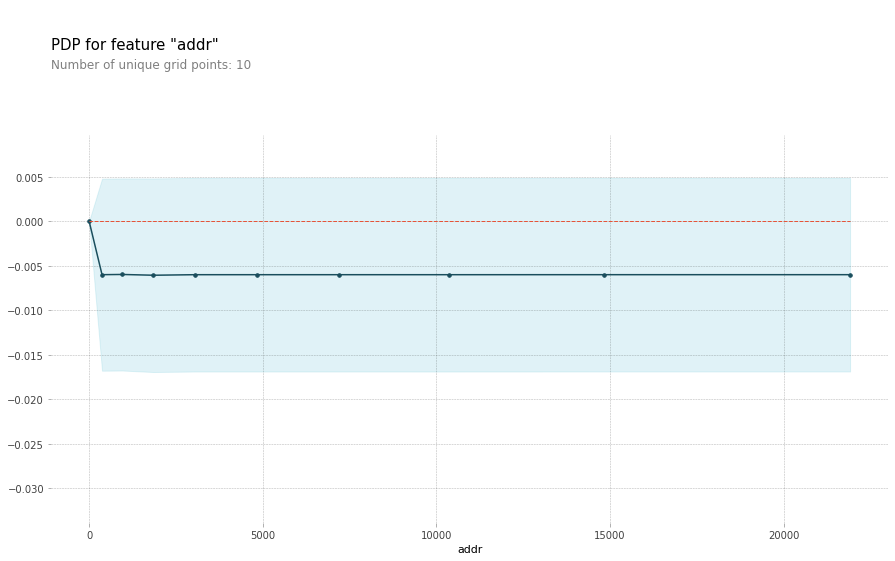

In [25]:
# 부분의존도그림(Partial dependence plots, PDP)을 사용하면 관심있는 특성들이 타겟에 어떻게 영향을 주는지 쉽게 파악할 수 있습니다.
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from pdpbox.pdp import pdp_interact, pdp_interact_plot


pipe = make_pipeline(
    OrdinalEncoder(), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
target = 'EMS'
features = df.columns

X = df[features]
y = df[target]
pipe.fit(X, y);
encoder = pipe.named_steps['ordinalencoder']
X_encoded = encoder.fit_transform(X)
rf = pipe.named_steps['randomforestclassifier']
import matplotlib.pyplot as plt
from pdpbox import pdp
feature = 'addr' # addr 특성이 타겟에 주는 영향을 시각화.
pdp_dist = pdp.pdp_isolate(model=rf, dataset=X_encoded, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature); 

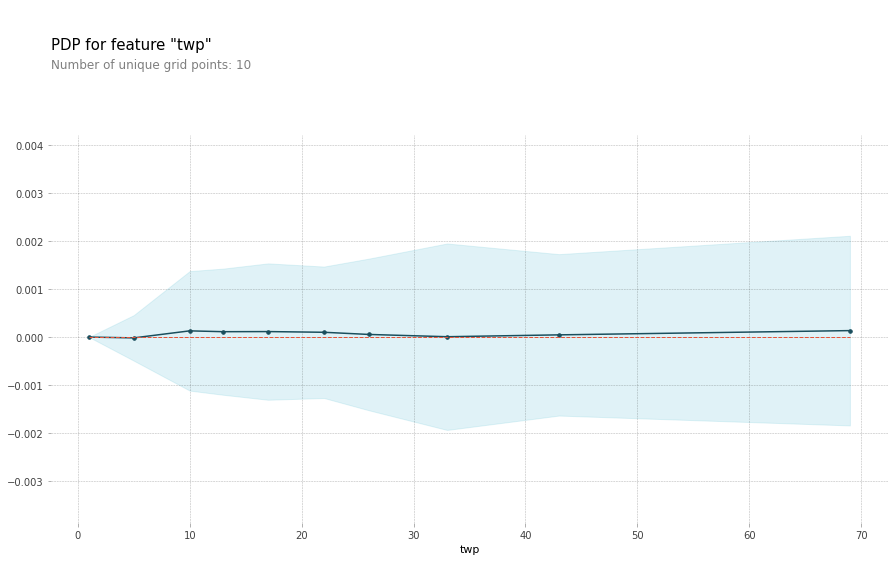

In [26]:
feature = 'twp'
pdp_dist = pdp.pdp_isolate(model=rf, dataset=X_encoded, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature); 